In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import os
import os.path as path
import glob
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

class MusicEncoder(nn.Module):
    def __init__(self, music_feats, music_emb, out_size=128, hid_size=256, num_layers=2, dropout=0.5, **kwargs):
        super().__init__()
        
        self.num_layers = num_layers
        self.music_embedding = nn.Linear(music_feats, music_emb)
        self.lstm = nn.LSTM(input_size = music_emb, hidden_size = hid_size, num_layers = num_layers, batch_first = True, bidirectional = True, dropout = dropout)

    def forward(self, music):
        music = self.music_embedding(music)
        _, hid = self.lstm(music)
        return hid[0][2*self.num_layers-2, :]
    
class PoseDecoder(nn.Module):
    def __init__(self, hid_size=256, out_size=128):
        super().__init__()
        self.prev_embedder = nn.Embedding(out_size, hid_size)
        self.cls = nn.Sequential(
            nn.Linear(2*hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, out_size)
        )
        self.out_size = out_size
        self.hid_size = hid_size
    def forward(self, music_emb, prev=None):
        prev_emb = torch.zeros((music_emb.size(0), self.hid_size), device=music_emb.device, dtype=music_emb.dtype) if prev is None else self.prev_embedder(prev)
        new_emb = torch.cat([music_emb, prev_emb], 1)
        return self.cls(new_emb)

In [2]:
enc = MusicEncoder(512, 256, 128, 256, 2, 0)
dec = PoseDecoder()

In [3]:
enc.load_state_dict(torch.load("enc.pt"))
dec.load_state_dict(torch.load("dec.pt"))

<All keys matched successfully>

In [8]:
class PairDataset(Dataset):
    def __init__(self, poses, music):
        super().__init__()
        self.poses = poses
        self.music = music
    def __getitem__(self, index):
        return self.music[index], self.poses[index]
    def __len__(self):
        return len(self.poses)

In [9]:
data = PairDataset(np.load("labels.npy"), np.load("music.npy"))

In [5]:
enc.to("cuda")
dec.to("cuda")
enc_optim = optim.SGD(enc.parameters(), lr=3e-4)
dec_optim = optim.SGD(dec.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss()

def train(epoch):
    print(f"Epoch: {epoch}")
    dataloader = DataLoader(data, batch_size=4)
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    total_loss = 0.0
    for i, batch in pbar:
        loss = torch.tensor(0.0).to("cuda")
        music, pose = batch
        music, pose = music.cuda(), pose.cuda()
        music = music.to(dtype=torch.float32).transpose(1, 2)
        pose = pose.to(dtype=torch.long)
        accuracy = 0.0
        
        music_enc = enc(music)
        for j in range(pose.size(1)):
            pose_pred = dec(music_enc, prev=pose[:, j-1] if i > 0 else None)
            loss += loss_func(pose_pred, pose[:, j])
            accuracy += (torch.argmax(pose_pred, 1) == pose[:, j]).sum().float() / pose.size(1)
            
        total_loss += loss.item()/pose.size(1)
        accuracy = accuracy.item()

        pbar.set_postfix(loss=loss.item()/pose.size(1), accuracy=accuracy)
        loss.backward()
        enc_optim.step()
        dec_optim.step()
    pbar.set_postfix(loss=(total_loss/len(dataloader)), accuracy=accuracy/len(dataloader))
    pbar.close()

In [6]:
[train(i) for i in range(10)]

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5



Epoch: 6



Epoch: 7



Epoch: 8



Epoch: 9


[None, None, None, None, None, None, None, None, None, None]

In [7]:
torch.save(enc.state_dict(), "enc.pt")
torch.save(dec.state_dict(), "dec.pt")

In [4]:
clusters = np.load("clusters.npy")
def evaluate(music):
    poses = []
    music = torch.tensor(music).cuda().to(dtype=torch.float32).transpose(0,1).unsqueeze(0)
    music_enc = enc(music)
    prev = None
    for i in range(10):
        pose_pred = dec(music_enc, prev=prev)
        prev = torch.topk(pose_pred.cpu(), 5)[1].squeeze().numpy()
        np.random.shuffle(prev)
        poses.append(prev[0].item())
        prev = torch.tensor(prev[0]).unsqueeze(0).cuda()
    return poses

def pose_array(poses):
    return np.concatenate([clusters[x].reshape(30, 15, 2) for x in poses], 0)

In [9]:
evaluate(data[1][0])

[120, 103, 86, 75, 21, 62, 57, 36, 17, 121]

In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from celluloid import Camera

BONE_LIST = [
    [0, 1],
    [1, 2], [2, 3], [3, 4],
    [1, 5], [5, 6], [6, 7],
    [1, 8],
    [8, 9], [9, 10], [10, 11],
    [8, 12], [12, 13], [13, 14]
]

def animate(poses, savename, fps=30, indices=None):
    """
    Animates the poses and saves to savename.
    :param poses: np.array of size (T, 15, 2)
    """
    camera = Camera(plt.figure())
    for i, pose in enumerate(poses):
        if indices is not None:
            pose_plot(pose, show=False, id_num=indices[i//30])
        else:
            pose_plot(pose, show=False)
        camera.snap()
    anim = camera.animate(blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
    writer = animation.FFMpegWriter(fps=fps)
    anim.save(savename, writer=writer)
    
    
def pose_plot(pose, show=True, pause=None, savepath=None, id_num=None):
    for i, j in BONE_LIST:
        plt.plot([pose[i, 0], pose[j, 0]], [pose[i, 1], pose[j, 1]], color='b')
    plt.scatter(pose[:, 0], pose[:, 1], color='blue')
    plt.gca().set_aspect('equal', adjustable='box')
    if id_num is not None:
        plt.annotate(id_num, (0, 0), xycoords='axes fraction')
    for i, coordinate in enumerate(pose):
        plt.annotate(i, coordinate, fontsize=10)
    if savepath is not None:
        plt.savefig(savepath)
    if show:
        if pause is None:
            plt.show()
        else:
            plt.show(block=False)
            plt.pause(pause)
            plt.close()

[80, 80, 126, 46, 110, 121, 46, 52, 82, 44]


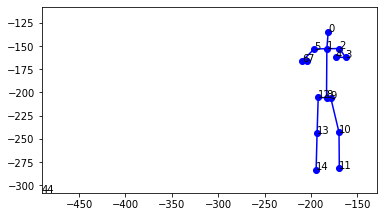

In [14]:
enc.cuda()
dec.cuda()
dance = evaluate(data[4][0])
print(dance)
animate(pose_array(dance), "dance4.mp4", indices=dance)

[ 48 126  66  66   0 123  26  48  70  44]


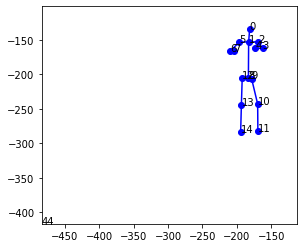

In [15]:
ground = data[4][1][:10]
print(ground)
animate(pose_array(ground), "ground4.mp4", indices=ground)